In [36]:
import sys
sys.path.insert(0, '../')
import torch

ckpt = torch.load("./hmodel_16_4.7.pt")
model = ckpt['model']
device = torch.device(0)
model.device = device
model.to(device)
print(type(model), model.device, model.fp16)

<class 'horizon.models.HorizonModel'> cuda:0 True


In [37]:
import numpy as np
import fiftyone as fo
from fiftyone import ViewField as F
import torch
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
from PIL import Image, ImageDraw

from horizon.dataloaders import HorizonDataset
from horizon.utils import draw_horizon
from utils.general import non_max_suppression

dataset_name = "TRAIN_THERMAL_DATASET_2023_06_16bit"
train_tag, val_tag = "TRAIN_v0", "VAL_v0"
imgsz = 640

dataset_name = "RGB_train_2023-03-28_local"
train_tag, val_tag = "val", "train"
imgsz = 1280

horizon_transform = A.Compose([
        A.LongestMaxSize(max_size=imgsz),
        A.HorizontalFlip(p=0.5),
        A.PadIfNeeded(min_height=imgsz, min_width=imgsz, border_mode=cv2.BORDER_CONSTANT), # letterbox
        A.Normalize(mean=0.0, std=1.0), # img = (img - mean * max_pixel_value) / (std * max_pixel_value)
        ToTensorV2(p=1.0),
    ], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

val_dataset = HorizonDataset(
    dataset=(fo.load_dataset(dataset_name)
             .match(F("ground_truth_pl.polylines.closed") == [False])
             .match_tags(val_tag)),  # only open polylines
    transform=horizon_transform,
    target_format="pitch_theta"
)

pitch=tensor([[0.53000]], device='cuda:0'), theta=tensor([[0.50400]], device='cuda:0')
pitch=tensor([[0.53980]], device='cuda:0'), theta=tensor([[0.50208]], device='cuda:0')
target=tensor([[0.53998, 0.50154]], dtype=torch.float64)


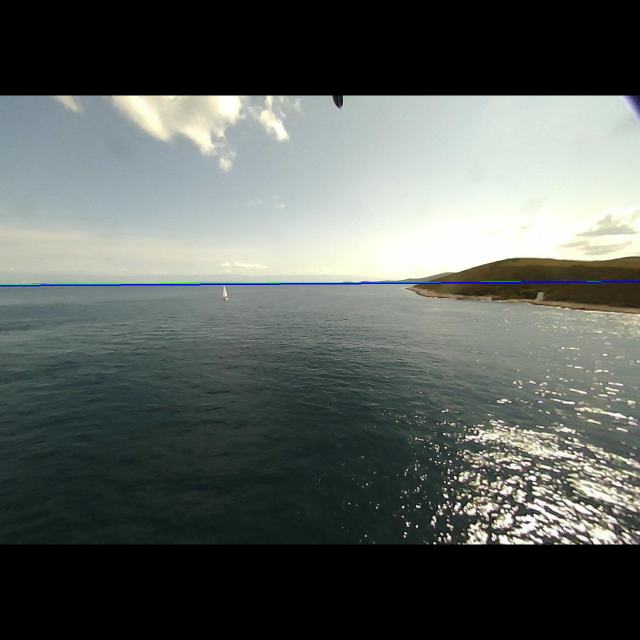

In [59]:
model.mode = None # "detection"
model.eval()

conf_thres = 0.1
iou_thres = 0.45
classes = None
agnostic_nms = True
max_det = 100

dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=1)

for image, target in dataloader:
    break

def preprocess(im, model):
    im = im.clone()  # avoid inplace modifications
    im = im.to(model.device)
    im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
    if im.max() > 1:
        im /= 255  # 0 - 255 to 0.0 - 1.0
    if len(im.shape) == 3:
        im = im[None]  # expand for batch dim
    return im

def inference(im, model):
    pred = model(im)
    return pred

def postprocess(pred):
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)
    return pred

def postprocess_x_pitch_theta(x_pitch, x_theta):
    def my_linspace(start, stop, num, device):
        # fake endpoint=False
        return torch.linspace(start, stop, num+1, device=device)[:-1]
    
    x_pitch, x_theta = x_pitch.softmax(1), x_theta.softmax(1)
    _, pitch = x_pitch.max(1, keepdim=True)
    pitch = pitch / x_pitch.shape[-1]
    _, theta = x_theta.max(1, keepdim=True)
    theta = theta / x_theta.shape[-1]
    print(f"{pitch=}, {theta=}")
    pitch = my_linspace(0, 1, model.nc_pitch, model.device).unsqueeze(0) * x_pitch
    theta = my_linspace(0, 1, model.nc_theta, model.device).unsqueeze(0) * x_theta
    pitch = pitch.sum(1, keepdim=True)
    theta = theta.sum(1, keepdim=True)
    print(f"{pitch=}, {theta=}")
    return pitch, theta

with torch.no_grad():
    im = preprocess(image, model=model)
    dets, x_pitch, x_theta = inference(im, model=model)
    dets = postprocess(dets)
    pitch, theta = postprocess_x_pitch_theta(x_pitch, x_theta)
    pitch, theta = pitch.detach().cpu(), theta.detach().cpu()
print(f"{target=}")

I = (image[0].permute(1,2,0) * 255).numpy().astype(np.uint8)
I = draw_horizon(I, pitch_theta=(target[0][0], target[0][1]), color=(0,255,0), diameter=2)
I = draw_horizon(I, pitch_theta=(pitch[0][0], theta[0][0]), color=(0,0,255), diameter=2)
I = Image.fromarray(I)
#draw = ImageDraw.Draw(I)
# for box in dets[0]:
#     draw.rectangle(list(box[:4]), outline='red', width=1)
I.reduce(2) if I.width >= 1024 else I

In [60]:
import pandas as pd
import plotly.express as px

pitch = x_pitch.softmax(1).squeeze().cpu().numpy()
theta = x_theta.softmax(1).squeeze().cpu().numpy()

val = np.concatenate([pitch, theta], axis=0)
x = np.concatenate([np.linspace(0, 1, len(pitch), endpoint=False), 
                    np.linspace(0, 1, len(theta), endpoint=False)])
name = np.concatenate([np.full(len(pitch), "pitch"), np.full(len(theta), "theta")])

df = pd.DataFrame({"x": x, "val": val, "name": name})
px.bar(df, x="x", y="val", color="name", barmode="overlay")